In [1]:
import numpy as np, statsmodels.stats.api as sms
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import random
from sklearn import preprocessing
import bootstrapped.bootstrap as bs
import bootstrapped.compare_functions as bs_compare
import bootstrapped.stats_functions as bs_stats
from termcolor import colored, cprint
import statsmodels.formula.api as smf

In [2]:
df = pd.read_csv('project_data.csv')

In [3]:
df.head()

,user,adid,week,expid,if_click,real_like_cnt,category,brand_effect,experience,status,user_age,friend_age,user_gender,friend_gender,user_city,friend_city,user_degree,friend_degree,user_sns_like_cnt,user_sns_comment_cnt
0,297353,0b0fa14b56d3741178196daaa92e6a1e,w_2,1,0,3,Car,1,1,1,48,37,female,male,level_1,level_1,495,436,162,138
1,98719,ea875acb76e0a806a7837174528f62d9,w_3,1,0,3,Car,1,1,1,29,34,female,female,level_3,level_2,479,3911,212,312
2,205144,1f1fe825014d9e9a0881233d9950bd43,w_2,1,0,1,Jewelry,0,1,1,24,24,female,male,level_2,level_1,682,470,95,336
3,559194,1f1fe825014d9e9a0881233d9950bd43,w_2,1,0,5,Jewelry,0,1,1,26,41,male,male,level_1,level_1,340,602,35,138
4,11888,0d82161270febc99f7defb653e339113,w_3,0,0,1,Cosmetrics,0,1,1,40,34,female,female,level_1,level_2,95,836,50,38


### **1. Correctly estimate variance**

#### Means with t tests

In [4]:
y0 = df[df['expid'] == 0]['if_click']
y1 = df[df['expid'] == 1]['if_click']
mean_d = np.mean(y1)-np.mean(y0)
print(mean_d)

0.007902000000000006


In [5]:
cm = sms.CompareMeans(sms.DescrStatsW(y0), sms.DescrStatsW(y1))
print(cm.ttest_ind(alternative='two-sided', usevar='unequal'))

(-15.430590532876625, 1.0340426453463637e-53, 997326.0389910816)


#### 1.1 traditional method of calculate variance

In [6]:
# variance of population
v0 = np.var(y0)
v1 = np.var(y1)
print(v0,v1)

0.06216790718374178 0.06895485596456183


In [7]:
# sample size 
n0 = len(y0)
n1 = len(y1)
print(n0,n1)

500000 500000


In [8]:
# variance of mean
v0_bar = v0/n0
v1_bar = v1/n1

In [9]:
v_delta = v0_bar+v1_bar
se_delat = np.sqrt(v_delta)

In [10]:
print('standand error of delta :',se_delat)

standand error of delta : 0.0005120991371761987


#### 1.2 Cluster standard error

In [11]:
import statsmodels.formula.api as smf
model = smf.ols(formula='if_click ~ expid', data=df)

##### OLS without Clustered SE

In [12]:
result_ols = model.fit()
print('Treatment effect without clustered errors')
print(result_ols.summary2())

Treatment effect without clustered errors
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.000      
Dependent Variable: if_click         AIC:                113112.6145
Date:               2023-03-03 20:25 BIC:                113136.2455
No. Observations:   1000000          Log-Likelihood:     -56554.    
Df Model:           1                F-statistic:        238.1      
Df Residuals:       999998           Prob (F-statistic): 1.03e-53   
R-squared:          0.000            Scale:              0.065562   
----------------------------------------------------------------------
               Coef.    Std.Err.      t       P>|t|    [0.025   0.975]
----------------------------------------------------------------------
Intercept      0.0666     0.0004   183.9335   0.0000   0.0659   0.0673
expid          0.0079     0.0005    15.4306   0.0000   0.0069   0.0089
--------------------------------------------------------------------
O

##### OLS with Clustered SE

In [13]:
result_cluster = model.fit(cov_type='cluster', cov_kwds = {'groups': df.user})
print('Treatment effect with clustered errors at user-level')
print(result_cluster.summary2())

Treatment effect with clustered errors at user-level
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.000      
Dependent Variable: if_click         AIC:                113112.6145
Date:               2023-03-03 20:25 BIC:                113136.2455
No. Observations:   1000000          Log-Likelihood:     -56554.    
Df Model:           1                F-statistic:        238.1      
Df Residuals:       999998           Prob (F-statistic): 1.03e-53   
R-squared:          0.000            Scale:              0.065562   
----------------------------------------------------------------------
               Coef.    Std.Err.      z       P>|z|    [0.025   0.975]
----------------------------------------------------------------------
Intercept      0.0666     0.0004   188.8869   0.0000   0.0659   0.0673
expid          0.0079     0.0005    15.4306   0.0000   0.0069   0.0089
-----------------------------------------------------------

In [14]:
df.groupby(['user'])['adid'].count().reset_index()

,user,adid
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
999995,999996,1
999996,999997,1
999997,999998,1
999998,999999,1


We can see that the result of cluster on user makes no difference with OLS without cluster. Then we check the data, and find one user will only see one ad, so no correlation within user across different ads.

In [15]:
result_cluster = model.fit(cov_type='cluster', cov_kwds = {'groups': df.adid})
print('Treatment effect with clustered errors at ad-level')
print(result_cluster.summary2())

Treatment effect with clustered errors at ad-level
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.000      
Dependent Variable: if_click         AIC:                113112.6145
Date:               2023-03-03 20:25 BIC:                113136.2455
No. Observations:   1000000          Log-Likelihood:     -56554.    
Df Model:           1                F-statistic:        46.61      
Df Residuals:       999998           Prob (F-statistic): 7.38e-07   
R-squared:          0.000            Scale:              0.065562   
----------------------------------------------------------------------
                Coef.    Std.Err.      z      P>|z|    [0.025   0.975]
----------------------------------------------------------------------
Intercept       0.0666     0.0046   14.3946   0.0000   0.0575   0.0757
expid           0.0079     0.0012    6.8268   0.0000   0.0056   0.0102
-------------------------------------------------------------

In [16]:
df.groupby(['category','adid'])['user'].count().reset_index().sort_values(by= 'user')

,category,adid,user
7,Car,6c21f585e63dd03012e9861bb501cbbc,37
11,Car,d446c604f22574f2d1f523a62091eb66,48
13,Car,e8ec07aa185dbcd55765628fc481942c,133
5,Car,1eeceb49bb35ba4f4127eb028767edc0,238
8,Car,88f460420dabe937becac2c4df5f9192,396
10,Car,c67481e9b64f1637e9b8ebe9b891fdae,535
2,Beverage,aba26e1c9dbe64e83550df881e84bddb,1769
20,Cosmetrics,54e1b7101869b70d061fbc5173f6ad53,2229
6,Car,216249750986b9a1ca17853f4e77d4ec,2324
9,Car,a16cdc60bdb8bffc25b9d02c525d5478,6473


In [17]:
df.groupby(['category'])['adid'].agg(['count','nunique']).reset_index()
#.sort_values(by= 'adid')

,category,count,nunique
0,Beverage,200000,4
1,Car,200000,11
2,Clothes,200000,1
3,Cosmetrics,200000,5
4,Jewelry,200000,2


- ols without cluster, standard error = 0.0005 
- ols with user as cluster, no difference
- ols with ad as cluster, standard error = 0.0012
- all of them has little effect on p-value

### **2. CUPED**

#### 2.1 Define CUPED

In [18]:
df.columns

Index(['user', 'adid', 'week', 'expid', 'if_click', 'real_like_cnt',
       'category', 'brand_effect', 'experience', 'status', 'user_age',
       'friend_age', 'user_gender', 'friend_gender', 'user_city',
       'friend_city', 'user_degree', 'friend_degree', 'user_sns_like_cnt',
       'user_sns_comment_cnt'],
      dtype='object')

In [19]:
con_variants= ['if_click','real_like_cnt','brand_effect', 'experience', 'status','user_age', 'friend_age', 'user_gender', 'friend_gender', 'user_city',
       'friend_city','user_degree', 'friend_degree', 'user_sns_like_cnt',
       'user_sns_comment_cnt']

In [20]:
# calculate correlation with if_click
df[con_variants].corr()

,if_click,real_like_cnt,brand_effect,experience,status,user_age,friend_age,user_degree,friend_degree,user_sns_like_cnt,user_sns_comment_cnt
if_click,1.000000,-0.002265,-0.014866,-0.027018,0.003186,0.004155,0.005996,0.008933,0.002936,0.002621,0.001086
real_like_cnt,-0.002265,1.000000,0.129271,0.024628,0.082673,-0.027331,-0.021665,0.279015,0.036452,0.090216,0.131973
brand_effect,-0.014866,0.129271,1.000000,-0.139926,0.427389,-0.050047,-0.043761,-0.045729,-0.028427,-0.026145,-0.025995
experience,-0.027018,0.024628,-0.139926,1.000000,-0.059803,-0.119116,-0.126880,-0.021956,-0.032770,0.006689,0.029606
status,0.003186,0.082673,0.427389,-0.059803,1.000000,0.158592,0.177741,-0.055248,-0.055169,-0.051431,-0.062871
user_age,0.004155,-0.027331,-0.050047,-0.119116,0.158592,1.000000,0.332870,0.055050,0.049221,-0.021033,-0.040419
friend_age,0.005996,-0.021665,-0.043761,-0.126880,0.177741,0.332870,1.000000,0.029959,0.083300,-0.027544,-0.033944
user_degree,0.008933,0.279015,-0.045729,-0.021956,-0.055248,0.055050,0.029959,1.000000,0.188220,0.201767,0.257600
friend_degree,0.002936,0.036452,-0.028427,-0.032770,-0.055169,0.049221,0.083300,0.188220,1.000000,0.034198,0.026263
user_sns_like_cnt,0.002621,0.090216,-0.026145,0.006689,-0.051431,-0.021033,-0.027544,0.201767,0.034198,1.000000,0.377225


None of them has correlation larger than 0.5

#### 1.2 T-test without CUPED

In [21]:
d_0 = df[df['expid'] == 0]['if_click']
d_1 = df[df['expid'] == 1]['if_click']
diff = np.mean(d_1) - np.mean(d_0)
print(diff)
cm = sms.CompareMeans(sms.DescrStatsW(d_1), sms.DescrStatsW(d_0))
ttest = cm.ttest_ind(alternative = 'two-sided', usevar = 'unequal')
se0 = cm.std_meandiff_separatevar
print(se0,ttest)

0.007902000000000006
0.0005120996492755023 (15.430590532876625, 1.0340426453463637e-53, 997326.0389910816)


#### 1.2 T-test with CUPED

In [22]:
def cuped(covariante):
    #np.cov returns a var-cov metrix
    cov_xy = np.cov(df[covariante],df.if_click, ddof=1)[0][1]
    var_x=np.var(df[covariante], ddof=1)
#     print('var_x',var_x)
    theta = cov_xy/var_x
#     print('theta',theta)
    df['theta']=theta 
    df['click_cuped']=df.if_click - df[covariante]*theta
    # t-test with cuped
    d_0 = df[df['expid'] == 0]['click_cuped']
    d_1 = df[df['expid'] == 1]['click_cuped']
    diff = np.mean(d_1) - np.mean(d_0)
#     print('diff',diff)
    cm = sms.CompareMeans(sms.DescrStatsW(d_1), sms.DescrStatsW(d_0))
    ttest = cm.ttest_ind(alternative = 'two-sided', usevar = 'unequal')
    se = cm.std_meandiff_separatevar
#     print('se and ttest:',se,ttest)
    return cov_xy,var_x,theta,diff,se,ttest

In [23]:
covariante = 'experience'
cov_xy,var_x,theta,diff,se,ttest = cuped(covariante)
var_reduction = (se0**2-se**2)/se0**2
print(f'Use {covariante.upper()} as control variante:')
print()
print(f'variance reduction: {round(var_reduction*100,2)}%')
print('cov_xy:',cov_xy)
print('var_x:',var_x)
print('theta:',theta)
print('diff:',diff)
print('se:',se)
print('ttest:',ttest)

Use EXPERIENCE as control variante:

variance reduction: 0.07%
cov_xy: -0.0007756945156945222
var_x: 0.012569908746008314
theta: -0.06171043333475678
diff: 0.007920759971753788
se: 0.0005119123752974531
ttest: (15.472882379789361, 5.365669266928558e-54, 997326.9864321109)


In [24]:
covariante = 'brand_effect'
cov_xy,var_x,theta,diff,se,ttest = cuped(covariante)
var_reduction = (se0**2-se**2)/se0**2
print(f'Use {covariante.upper()} as control variante:')
print()
print(f'variance reduction: {round(var_reduction*100,2)}%')
print('cov_xy:',cov_xy)
print('var_x:',var_x)
print('theta:',theta)
print('diff:',diff)
print('se:',se)
print('ttest:',ttest)

Use BRAND_EFFECT as control variante:

variance reduction: 0.02%
cov_xy: -0.001862674582674576
var_x: 0.23941265259798586
theta: -0.007780184390681808
diff: 0.007901875516915471
se: 0.0005120430498411305
ttest: (15.432053065655873, 1.0108773162890724e-53, 997328.3654270597)


In [25]:
covariante = 'user_age'
cov_xy,var_x,theta,diff,se,ttest = cuped(covariante)
var_reduction = (se0**2-se**2)/se0**2
print(f'Use {covariante.upper()} as control variante:')
print()
print(f'variance reduction: {round(var_reduction*100,2)}%')
print('cov_xy:',cov_xy)
print('var_x:',var_x)
print('theta:',theta)
print('diff:',diff)
print('se:',se)
print('ttest:',ttest)

Use USER_AGE as control variante:

variance reduction: 0.0%
cov_xy: 0.007002178657178631
var_x: 43.315133278677244
theta: 0.0001616566342328582
diff: 0.007900794364821738
se: 0.0005120952470405101
ttest: (15.42836886396042, 1.0702473447543241e-53, 997327.2349534295)


In [26]:
covariante ='friend_degree'
cov_xy,var_x,theta,diff,se,ttest = cuped(covariante)
var_reduction = (se0**2-se**2)/se0**2
print(f'Use {covariante.upper()} as control variante:')
print()
print(f'variance reduction: {round(var_reduction*100,2)}%')
print('cov_xy:',cov_xy)
print('var_x:',var_x)
print('theta:',theta)
print('diff:',diff)
print('se:',se)
print('ttest:',ttest)

Use FRIEND_DEGREE as control variante:

variance reduction: 0.0%
cov_xy: 0.6452228209628188
var_x: 736272.6950302899
theta: 8.763367503887599e-07
diff: 0.007906081135297824
se: 0.0005120973779867574
ttest: (15.438628423331805, 9.129516063058259e-54, 997325.1275208826)


### **3. Regression**

In [27]:
mod = smf.ols(formula='if_click ~  expid', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               if_click   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     238.1
Date:                Fri, 03 Mar 2023   Prob (F-statistic):           1.03e-53
Time:                        20:25:55   Log-Likelihood:                -56554.
No. Observations:             1000000   AIC:                         1.131e+05
Df Residuals:                  999998   BIC:                         1.131e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0666      0.000    183.933      0.0

In [28]:
# relative friend status
df['friends_relative_social_status']= np.log(df['friend_degree'])-np.log(df['user_degree'])
# Z-Score using pandas
df['friends_relative_social_status'] = (df['friends_relative_social_status'] - df['friends_relative_social_status'].mean()) / df['friends_relative_social_status'].std()

In [29]:
# with clustered standard error
mod = smf.ols(formula='if_click ~  expid + expid*friends_relative_social_status', data=df)
res = mod.fit(cov_type='cluster', cov_kwds = {'groups': df.adid})
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               if_click   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     24.12
Date:                Fri, 03 Mar 2023   Prob (F-statistic):           3.80e-07
Time:                        20:25:57   Log-Likelihood:                -56548.
No. Observations:             1000000   AIC:                         1.131e+05
Df Residuals:                  999996   BIC:                         1.132e+05
Df Model:                           3                                         
Covariance Type:              cluster                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [30]:
# without clustered standard error
mod = smf.ols(formula='if_click ~  expid + expid*friends_relative_social_status', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               if_click   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     83.80
Date:                Fri, 03 Mar 2023   Prob (F-statistic):           3.29e-54
Time:                        20:25:58   Log-Likelihood:                -56548.
No. Observations:             1000000   AIC:                         1.131e+05
Df Residuals:                  999996   BIC:                         1.132e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [31]:
# with clustered standard error
mod = smf.ols(formula='if_click ~  expid + friends_relative_social_status', data=df)
res = mod.fit(cov_type='cluster', cov_kwds = {'groups': df.adid})
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               if_click   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     23.65
Date:                Fri, 03 Mar 2023   Prob (F-statistic):           3.30e-06
Time:                        20:26:00   Log-Likelihood:                -56550.
No. Observations:             1000000   AIC:                         1.131e+05
Df Residuals:                  999997   BIC:                         1.131e+05
Df Model:                           2                                         
Covariance Type:              cluster                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

In [32]:
# without clustered standard error
mod = smf.ols(formula='if_click ~  expid + friends_relative_social_status', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               if_click   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     123.6
Date:                Fri, 03 Mar 2023   Prob (F-statistic):           2.14e-54
Time:                        20:26:00   Log-Likelihood:                -56550.
No. Observations:             1000000   AIC:                         1.131e+05
Df Residuals:                  999997   BIC:                         1.131e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Relative social status has a positive effect for adding social cue to social ads, so the platform can display the friends that has higher social status as social cues.

### **4. Lift Effect**

In [33]:
n = 1000000
d_0 = df[df['expid'] == 0]['if_click']
d_1 = df[df['expid'] == 1]['if_click']
m0 = np.mean(d_0)
m1 = np.mean(d_1)
lift = m1/m0
print(lift)

1.1186415230316498


In [34]:
var0 = np.var(d_0,ddof=1)
var1 = np.var(d_1,ddof=1)
var_m0 = var0/500000
var_m1 = var1/500000

##### Delta method

In [35]:
var_lift = 1/(m0**2)*var_m1 + (m1**2)/(m0**4)*var_m0
se_lift = np.sqrt(var_lift)
print(var_lift,se_lift)

6.61616051913808e-05 0.008133978435635344


In [36]:
CI = [lift- 1.96*se_lift,lift+1.96*se_lift]
print(CI)

[1.1026989252978046, 1.134584120765495]


In [37]:
# null hypothesis is there is no difference in click through rate, so lift0 = 1
t_stat = (lift-1)/se_lift
print(t_stat)

14.585915609497517


In [38]:
from scipy.stats import t
pval = t.sf(np.abs(t_stat), n-1)*2  # two-sided pvalue = Prob(abs(t)>tt)
print('t-statistic = %6.3f pvalue = %6.4f' % (t_stat, pval))

t-statistic = 14.586 pvalue = 0.0000


##### Bootstramp
I trie to use bootstrap method to calculate CI for lift, but if failed on my computer

In [39]:
# import bootstrapped.bootstrap as bs
# import bootstrapped.compare_functions as bs_compare
# import bootstrapped.stats_functions as bs_stats

In [40]:
# print(bs.bootstrap_ab(
#     np.array(d_1), 
#     np.array(d_0), 
#     stat_func=bs_stats.mean,
#     compare_func=bs_compare.percent_change,
#     alpha=0.05))

### **5. heterogeneous effect of dyadic similarities between friends and ad viewers**

##### Data Preprocessing 

In [41]:
 def week_trans(x):
    if x=="w_1":
        return 1
    if x=="w_2":
        return 2
    if x=="w_3":
        return 3
    else :
        return x

In [42]:
def city_trans(x):
    if x=="level_1":
        return 1
    if x=="level_2":
        return 2
    if x=="level_3":
        return 3
    else :
        return x

In [43]:
df['user_gender'] = df['user_gender'].apply( lambda x:1 if x=='male' else 0)
df['friend_gender'] = df['friend_gender'].apply( lambda x:1 if x=='male' else 0)
df['week'] = df['week'].apply(week_trans)
df['user_city']= df['user_city'].apply(city_trans)
df['friend_city']=df['friend_city'].apply(city_trans)

In [44]:
# same 1 not same 0 
def dummy(a, b):
    if a == b:
        return 1
    else:
        return 0

In [45]:
df['same_gender'] = df.apply(lambda x : dummy(x['user_gender'],x['friend_gender']),axis = 1)

In [46]:
df[['user_gender','friend_gender','same_gender']].head()

,user_gender,friend_gender,same_gender
0,0,1,0
1,0,0,1
2,0,1,0
3,1,1,1
4,0,0,1


In [47]:
df['same_city'] = df.apply(lambda x : dummy(x['user_city'],x['friend_city']),axis = 1)

In [48]:
df[['user_city','friend_city','same_city']].head()

,user_city,friend_city,same_city
0,1,1,1
1,3,2,0
2,2,1,0
3,1,1,1
4,1,2,0


##### Gender similarity between user and friend

In [49]:
# Across gender similarity
gender_list = [1, 0]
gender_res = []
for x in gender_list:
    tmp_d_0 = df[(df['expid'] == 0) & (df['same_gender'] == x)]['if_click']
    tmp_d_1 = df[(df['expid'] == 1) & (df['same_gender'] == x)]['if_click']
    tmp_diff = np.mean(tmp_d_1) - np.mean(tmp_d_0)
    tmp_cm = sms.CompareMeans(sms.DescrStatsW(tmp_d_1), sms.DescrStatsW(tmp_d_0))
    tmp_ci = tmp_cm.tconfint_diff(alpha = 0.05, alternative = 'two-sided', usevar = 'unequal')
    gender_res.append([x, tmp_diff, tmp_ci])
print(gender_res) 

[[1, 0.006727231919533144, (0.0053087625166157275, 0.008145701322450561)], [0, 0.009073783783327738, (0.0076533711229696865, 0.01049419644368579)]]


[Text(0, 0, 'same gender'), Text(1, 0, 'opposite gender')]

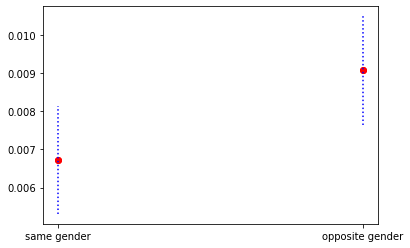

In [50]:
# Plot CATE for gender similarity
for i in range(len(gender_res)):
    diff = gender_res[i][1]
    ci = gender_res[i][2]
    plt.plot([i, i], [diff, diff], "or")
    plt.plot([i, i], [ci[0], ci[1]], ":b")
f = plt.gca()
f.set_xticks(range(len(gender_res)))
f.set_xticklabels(['same gender','opposite gender'])

#### city level similarity between user and friend

In [51]:
# Across city level similarity
city_list = [1, 0]
city_res = []
for x in city_list:
    tmp_d_0 = df[(df['expid'] == 0) & (df['same_city'] == x)]['if_click']
    tmp_d_1 = df[(df['expid'] == 1) & (df['same_city'] == x)]['if_click']
    tmp_diff = np.mean(tmp_d_1) - np.mean(tmp_d_0)
    tmp_cm = sms.CompareMeans(sms.DescrStatsW(tmp_d_1), sms.DescrStatsW(tmp_d_0))
    tmp_ci = tmp_cm.tconfint_diff(alpha = 0.05, alternative = 'two-sided', usevar = 'unequal')
    city_res.append([x, tmp_diff, tmp_ci])
print(city_res) 

[[1, 0.0077468482146353795, (0.006289129551123854, 0.009204566878146905)], [0, 0.00804202069429455, (0.006657985733034827, 0.009426055655554271)]]


[Text(0, 0, 'same city level'), Text(1, 0, 'different city level')]

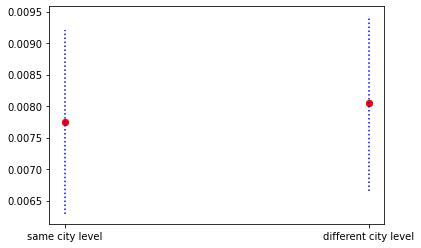

In [52]:
# Plot CATE for city level similarity
for i in range(len(city_res)):
    diff = city_res[i][1]
    ci = city_res[i][2]
    plt.plot([i, i], [diff, diff], "or")
    plt.plot([i, i], [ci[0], ci[1]], ":b")
f = plt.gca()
f.set_xticks(range(len(city_res)))
f.set_xticklabels(['same city level','different city level'])